## Gradient-based Inverse Design Maximize Qfwd while Minimize Qback
---

### <u> Import modules <u/>

In [1]:
import tensorflow as tf
import os
import sys
import ast
import numpy as np
import pandas as pd
import pickle
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import time

from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
import torch
from torch.utils.data import DataLoader, TensorDataset

# from tensorflow.keras.mixed_precision import set_global_policy

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from wgangp_model import WGAN_GP, load_generator, generate_synthetic_data, inverse_transform_synthetic_data


from evaluation_protocol import calculate_emd, calculate_ks_test, calculate_js_divergence, calculate_sbasic, calculate_scorr, calculate_smirr, calculate_spca
from utils_plot import plot_best_geometries_by_weights

os.environ["KERAS_BACKEND"] = "tensorflow"


2024-12-20 17:37:39.929482: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 17:37:39.936676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-20 17:37:39.945055: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-20 17:37:39.947591: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 17:37:39.954084: I tensorflow/core/platform/cpu_feature_guar

## Set dynamic GPU memory growth

In [2]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

# Set the mixed precision policy
# set_global_policy('mixed_float16')


GPU is available and set to memory growth mode.


I0000 00:00:1734691887.257706    8394 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734691887.259709    8394 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734691887.260847    8394 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


### Define the own resblock class

keras requires custom classes to be defined for being able to reload

In [3]:
# decorator to register the custom resblock to allow serialziation and re-loading
@keras.utils.register_keras_serializable() # for keras3
class ResBlock1D(keras.Model):
    def __init__(self, filters, kernel_size=3, convblock=False, **kwargs):
        super(ResBlock1D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        # setup all necessary layers
        self.conv1 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn1 = keras.layers.BatchNormalization()

        self.conv2 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn2 = keras.layers.BatchNormalization()

        # self.relu = keras.layers.LeakyReLU()
        self.relu = keras.layers.LeakyReLU(negative_slope=0.01)

        self.convblock = convblock
        if self.convblock:
            self.conv_shortcut = keras.layers.Conv1D(filters, 1)

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # add shortcut. optionally pass it through a Conv
        if self.convblock:
            x_sc = self.conv_shortcut(input_tensor)
        else:
            x_sc = input_tensor
        x += x_sc
        return self.relu(x)

    def get_config(self):
        base_config = super().get_config()
        return {
            "convblock": self.convblock,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            **base_config,
        }


## Relaod the data scaler

In [4]:
# preprocessor path
preprocessor_path = "datasets/newData_122500/04_shuffle_features_scaler_MinMax(-1,1)_OneHot.pkl"
scaler_Qfwd_path = "datasets/newData_122500/04_shuffle_Qfwd_target_MinMaxScaler_-1-1.pkl"
scaler_Qback_path = "datasets/newData_122500/04_shuffle_Qback_target_MinMaxScaler_-1-1.pkl"


# Load the preprocessors and scalers
with open(preprocessor_path, "rb") as f:
    preprocessor = pickle.load(f)
with open(scaler_Qfwd_path, "rb") as f:
    scaler_Qfwd = pickle.load(f)
with open(scaler_Qback_path, "rb") as f:
    scaler_Qback = pickle.load(f)

## Reload the forward and wgangp model

In [5]:
forward_path = "models/resnet/newData_122500/04_keras3_increaseBatch_decayLR_hybridMode.keras"

wgangp_path = 'models/wgangp_tf/newData_122500/03_generator_tf_batch122500_noise128_weight10_40000epoch_generator.h5'           #wgangp TF backend


forward_model = keras.models.load_model(forward_path)
generator = load_generator(wgangp_path)

I0000 00:00:1734691891.162909    8394 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734691891.163959    8394 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734691891.164787    8394 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734691891.278288    8394 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## Utils

In [6]:
# %% --- Mie
def get_Mie_spec(wavelengths, r_core, r_shell, mat_core, mat_shell, n_env):

    k0 = 2 * np.pi / wavelengths
    n_core = mat_core.get_refindex(wavelengths)
    n_shell = mat_shell.get_refindex(wavelengths)

    res = pymiecs.Q(
        k0,
        r_core=r_core,
        n_core=n_core,
        r_shell=r_shell,
        n_shell=n_shell,
        n_env=n_env.real**0.5,  # host medium must be lossless
    )
    return (
        res['qsca'],
        res['qback'],
        res['qfwd'],
    )

In [7]:
# from Mie_Function import CustomMaterial, get_Mie_spec
# from pyGDM2 import materials
import pymiecs
Si = pymiecs.materials.MaterialDatabase('Si')
SiO2 = pymiecs.materials.MaterialDatabase('SiO2')
Si3N4 = pymiecs.materials.MaterialDatabase('Si3N4')
Au = pymiecs.materials.MaterialDatabase('Au')
Ag = pymiecs.materials.MaterialDatabase('Ag')
ZrO2 = pymiecs.materials.MaterialDatabase('ZrO2')
TiO2 = pymiecs.materials.MaterialDatabase('TiO2')


# Define a function to map material names to material objects
def get_material(material_name):
    if material_name == 'Si':
        return Si
    elif material_name == 'SiO2':
        return SiO2
    elif material_name == 'Au':
        return Au
    elif material_name == 'Ag':
        return Ag
    elif material_name == 'Si3N4':
        return Si3N4
    elif material_name == 'ZrO2':
        return ZrO2
    elif material_name == 'TiO2':
        return TiO2
    else:
        raise ValueError(f"Unknown material: {material_name}")

## Define Target


In [8]:
wavelengths = np.linspace(400, 800, 64)  # original wavelength array
print(f"wavelengths:{wavelengths}")
target_lambda_index = np.argmin(np.abs(wavelengths - 705))  

print(f"Target wavelength index {target_lambda_index} ({wavelengths[target_lambda_index]} nm)")

wavelengths:[400.         406.34920635 412.6984127  419.04761905 425.3968254
 431.74603175 438.0952381  444.44444444 450.79365079 457.14285714
 463.49206349 469.84126984 476.19047619 482.53968254 488.88888889
 495.23809524 501.58730159 507.93650794 514.28571429 520.63492063
 526.98412698 533.33333333 539.68253968 546.03174603 552.38095238
 558.73015873 565.07936508 571.42857143 577.77777778 584.12698413
 590.47619048 596.82539683 603.17460317 609.52380952 615.87301587
 622.22222222 628.57142857 634.92063492 641.26984127 647.61904762
 653.96825397 660.31746032 666.66666667 673.01587302 679.36507937
 685.71428571 692.06349206 698.41269841 704.76190476 711.11111111
 717.46031746 723.80952381 730.15873016 736.50793651 742.85714286
 749.20634921 755.55555556 761.9047619  768.25396825 774.6031746
 780.95238095 787.3015873  793.65079365 800.        ]
Target wavelength index 48 (704.7619047619048 nm)


## Maximize Qfwd Minimize Qback Fitness function
---
Add Series Weight

In [9]:
def objective_function_weight_series(z_batch, generator, forward_model, target_lambda_index, weight_Qback):
    synthetic_geometries = generator(z_batch)
    synthetic_geometries_concat = keras.ops.concatenate(synthetic_geometries, axis=1) # Concatenate numerical and categorical outputs

    # Forward pass through the forward model
    predicted_batch = forward_model(synthetic_geometries_concat)
    
    # Split output from the forward model
    predicted_Qfwd_batch = predicted_batch[..., 0]  # Qfwd is the first channel
    predicted_Qback_batch = predicted_batch[..., 1]  # Qback is the second channel

    # Extract values at the target wavelength index
    fitness_fwd = -predicted_Qfwd_batch[:, target_lambda_index]  # Maximize Qfwd
    fitness_back = predicted_Qback_batch[:, target_lambda_index] * weight_Qback # Minimize Qback
    # Combine to get total loss
    total_loss_batch = fitness_fwd + fitness_back
    return total_loss_batch


# leanring rate schedule function
def learning_rate_schedule(iteration, initial_lr=0.01):
    # Custom schedule for 250 iterations
    if iteration < 10:
        return initial_lr  # Initial high learning rate for exploration
    elif 10 <= iteration < 30:
        return initial_lr * 0.1  # Reduce learning rate for refinement
    else:
        return initial_lr * 0.01

In [11]:
def optimize_latent_vector_weight_series_parallel(z_batch, generator, forward_model, target_lambda_index, weight_Qback, lr_strategy='fixed', initial_lr=0.01, iterations=250, learning_rates=None):

    if lr_strategy == 'fixed':
        optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)  # Fixed learning rate
    elif lr_strategy == 'schedule':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule(0, initial_lr))  # Use schedule initially
    elif lr_strategy == 'loop' and learning_rates is None:
        raise ValueError("Learning rates must be provided for 'loop' strategy.")

    loss_history = []

    for i in range(iterations):
        if lr_strategy == 'schedule':
            # Update the learning rate based on the schedule
            new_learning_rate = learning_rate_schedule(i, initial_lr)
            optimizer.learning_rate.assign(new_learning_rate)

        with tf.GradientTape() as tape:
            # Calculate the loss for the batch of latent vectors
            total_loss_batch = objective_function_weight_series(z_batch, generator, forward_model, target_lambda_index, weight_Qback)

        # Get gradients and update latent vectors in the batch
        gradients_batch = tape.gradient(total_loss_batch, [z_batch])
        optimizer.apply_gradients(zip(gradients_batch, [z_batch]))

        mean_loss = tf.reduce_mean(total_loss_batch).numpy()
        loss_history.append(total_loss_batch.numpy())

        # Print progress every 50 iterations for better tracking
        if i % 50 == 0:
            print(f"Iteration {i}, Mean Loss: {mean_loss:.6f}")

    # Calculate final loss for the batch after all iterations
    final_loss = tf.reduce_mean(total_loss_batch).numpy()

    return z_batch, final_loss, loss_history

## Running Optimization Weight Series

In [15]:
# Initialize variables
lr_strategy = 'loop'  # Set to 'fixed', 'loop', or 'schedule' to choose the strategy

batch_size = 500        
latent_dim = 128         

weight_series = [0, 0.5, 1, 5]  # List of weights for Qback penalty
learning_rates = [0.00001, 0.0001, 0.001, 0.01]  # Learning rates for 'loop' strategy
initial_learning_rate = 0.01  # Initial learning rate for 'fixed' and 'schedule' strategies
iterations = 250
results = []

In [16]:
# Loop through each weight in the weight series
for weight_Qback in weight_series:
    if lr_strategy == 'loop':
        # Loop over learning rates
        for lr in learning_rates:
            print(f"\nRunning optimization with '{lr_strategy}' strategy, weight {weight_Qback}, learning rate {lr}")

            # Initialize a batch of random latent vectors
            initial_z_batch = np.random.normal(size=(batch_size, latent_dim)) * 2
            z_batch_tf = tf.Variable(initial_z_batch, dtype=tf.float32)

            start_time = time.time()

            # Optimize the latent vectors for the current weight and learning rate
            optimized_z_batch, final_loss, loss_history = optimize_latent_vector_weight_series_parallel(
                z_batch_tf,
                generator,
                forward_model,
                target_lambda_index,
                weight_Qback,
                lr_strategy='fixed',  # Use 'fixed' here because each loop uses a different fixed LR
                initial_lr=lr,
                iterations=iterations
            )

            end_time = time.time()
            elapsed_time = end_time - start_time

            # Store the optimized latent vectors and final loss for this weight and learning rate
            results.append({
                'weight_Qback': weight_Qback,
                'learning_rate': lr,
                'lr_strategy': lr_strategy,
                'optimized_z_batch': optimized_z_batch,
                'final_loss': final_loss,
                'loss_history': loss_history
            })
    elif lr_strategy == 'schedule':
        # Use the schedule learning rate strategy
        print(f"\nRunning optimization with '{lr_strategy}' strategy, weight {weight_Qback}")

        # Initialize a batch of random latent vectors
        initial_z_batch = np.random.normal(size=(batch_size, latent_dim))# * 2
        z_batch_tf = tf.Variable(initial_z_batch, dtype=tf.float32)

        start_time = time.time()

        # Optimize the latent vectors for the current weight
        optimized_z_batch, final_loss, loss_history = optimize_latent_vector_weight_series_parallel(
            z_batch_tf,
            generator,
            forward_model,
            target_lambda_index,
            weight_Qback,
            lr_strategy=lr_strategy,
            initial_lr=initial_learning_rate,
            iterations=iterations
        )

        end_time = time.time()
        elapsed_time = end_time - start_time

        # Store the optimized latent vectors and final loss for this weight
        results.append({
            'weight_Qback': weight_Qback,
            'learning_rate': initial_learning_rate,
            'lr_strategy': lr_strategy,
            'optimized_z_batch': optimized_z_batch,
            'final_loss': final_loss,
            'loss_history': loss_history
        })
    else:
        # Use the fixed or schedule learning rate strategy
        print(f"\nRunning optimization with '{lr_strategy}' strategy, weight {weight_Qback}")

        # Initialize a batch of random latent vectors
        initial_z_batch = np.random.normal(size=(batch_size, latent_dim)) * 2
        z_batch_tf = tf.Variable(initial_z_batch, dtype=tf.float32)

        start_time = time.time()

        # Optimize the latent vectors for the current weight
        optimized_z_batch, final_loss, loss_history = optimize_latent_vector_weight_series_parallel(
            z_batch_tf,
            generator,
            forward_model,
            target_lambda_index,
            weight_Qback,
            lr_strategy='fixed',
            initial_lr=initial_learning_rate,
            iterations=iterations
        )

        end_time = time.time()
        elapsed_time = end_time - start_time

        # Store the optimized latent vectors and final loss for this weight
        results.append({
            'weight_Qback': weight_Qback,
            'learning_rate': initial_learning_rate,
            'lr_strategy': lr_strategy,
            'optimized_z_batch': optimized_z_batch,
            'final_loss': final_loss,
            'loss_history': loss_history
        })

# Print summary of results
for result in results:
    print(f"\nStrategy: {result['lr_strategy']}, Weight: {result['weight_Qback']}, Learning Rate: {result['learning_rate']}")
    print(f"Final Loss: {result['final_loss']:.4f}")


Running optimization with 'loop' strategy, weight 0, learning rate 1e-05


W0000 00:00:1734689209.439900    4025 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734689209.440144    4025 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734689209.440333    4025 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734689209.440526    4025 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734689209.440704    4025 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734689209.440863    4025 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734689209.441022    4025 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734689209.441262    4025 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734689209.441430    4025 gp

Iteration 0, Mean Loss: 0.321964
Iteration 50, Mean Loss: 0.315328
Iteration 100, Mean Loss: 0.307862
Iteration 150, Mean Loss: 0.301369
Iteration 200, Mean Loss: 0.295347

Running optimization with 'loop' strategy, weight 0, learning rate 0.0001
Iteration 0, Mean Loss: 0.393491
Iteration 50, Mean Loss: 0.339224
Iteration 100, Mean Loss: 0.289357
Iteration 150, Mean Loss: 0.249531
Iteration 200, Mean Loss: 0.212337

Running optimization with 'loop' strategy, weight 0, learning rate 0.001
Iteration 0, Mean Loss: 0.347704
Iteration 50, Mean Loss: 0.000385
Iteration 100, Mean Loss: -0.169388
Iteration 150, Mean Loss: -0.242587
Iteration 200, Mean Loss: -0.268265

Running optimization with 'loop' strategy, weight 0, learning rate 0.01
Iteration 0, Mean Loss: 0.383778
Iteration 50, Mean Loss: -0.298281
Iteration 100, Mean Loss: -0.350321
Iteration 150, Mean Loss: -0.359812
Iteration 200, Mean Loss: -0.365796

Running optimization with 'loop' strategy, weight 0.5, learning rate 1e-05
Iterati

In [70]:
"""
save result dictionary for later use
"""
# with open('result_dict/02_LrSched_lossHistory.pkl', 'wb') as pickle_file:
#     pickle.dump(results, pickle_file)


"""
Load Results
"""
# results = []
# results_path = 'result_dict/02_LrSched_lossHistory.pkl'

# # Load the preprocessors and scalers
# with open(results_path, 'rb') as f:
#     results = pickle.load(f)

## Evaluate the Optimization

In [41]:
# Define columns and file path
desired_columns = ['mat_core', 'mat_shell', 'r_core', 'r_shell']
generated_columns = ['r_core', 'r_shell', 'mat_core', 'mat_shell']

In [42]:
def process_results(results, generator, preprocessor, forward_model, target_lambda_index, generated_columns, desired_columns):
    best_geometries_by_weight = {}

    for result in results:
        weight_Qback = result['weight_Qback']
        
        # Generate synthetic geometries
        optimized_z_batch = result['optimized_z_batch']
        synthetic_geometries = generator(optimized_z_batch)
        synthetic_geometries_concat = tf.concat(synthetic_geometries, axis=1)

        # Inverse transform synthetic data
        inverse_synthetic_data = inverse_transform_synthetic_data(preprocessor, synthetic_geometries)
        optimized_geometries_df = pd.DataFrame(inverse_synthetic_data, columns=generated_columns)
        optimized_geometries_df = optimized_geometries_df[desired_columns]

        # Calculate total loss
        total_loss_batch = objective_function_weight_series(optimized_z_batch, generator, forward_model, target_lambda_index, weight_Qback)
        total_loss_numpy = total_loss_batch.numpy()
        optimized_geometries_df['Total Loss'] = total_loss_numpy

        # Sort the geometries by Total Loss
        optimized_geometries_df_sorted = optimized_geometries_df.sort_values(by='Total Loss', ascending=True)

        # Track unique combinations of core and shell materials
        seen_combinations = set()
        best_geometries_list = []

        # Iterate over sorted geometries to select the best distinct ones
        for _, row in optimized_geometries_df_sorted.iterrows():
            core_shell_combination = (row['mat_core'], row['mat_shell'])
            if core_shell_combination not in seen_combinations:
                seen_combinations.add(core_shell_combination)
                best_geometries_list.append(row)

                # Stop if we have found the desired number of distinct geometries
                if len(best_geometries_list) == 10:
                    break

        # Convert the selected rows back to a DataFrame
        best_10_geometries = pd.DataFrame(best_geometries_list)

        # Select the best 5 geometries
        if weight_Qback in [0, 0.5]:
            # best_5_geometries = best_10_geometries.sample(frac=1).reset_index(drop=True).head(5)
            best_5_geometries = best_10_geometries.head(5)

        elif weight_Qback in [1, 5]:
            best_5_geometries = best_10_geometries.head(5)

        # Store the best 5 geometries for the current weight
        best_geometries_by_weight[weight_Qback] = best_5_geometries

    return optimized_geometries_df_sorted, best_geometries_by_weight

In [43]:
best_geometries_by_weight = process_results(results, generator, preprocessor, forward_model, target_lambda_index, generated_columns, desired_columns)
best_geometries_by_weight[0]

,mat_core,mat_shell,r_core,r_shell,Total Loss
28,SiO2,Si,35.965538,130.438690,-0.995748
34,ZrO2,TiO2,91.928215,182.725861,-0.995686
30,Si3N4,Si,40.991898,130.978516,-0.968979
24,TiO2,TiO2,92.202560,181.513580,-0.912989
14,Ag,TiO2,23.596607,123.633621,-0.790194


In [72]:
# Predict Qfwd and Qback using forward model and Calculate Qfwd and Qback using pyMieScatt with more wavelength (128 points)

categorical_features = ['mat_core', 'mat_shell'] 
numerical_features = ['r_core', 'r_shell']

wavelengths_original = np.linspace(400, 800, 64)
wavelengths_new = np.linspace(500, 800, 128) 

# Loop through each weight and update the DataFrame with predicted and Mie values
for weight, best_geometries in best_geometries_by_weight.items():
    X_optimized_preprocessed = preprocessor.transform(best_geometries[categorical_features + numerical_features])  # transform the data
    # Predict using the forward model
    y_pred = forward_model.predict(X_optimized_preprocessed)

    y_pred_Qfwd = y_pred[..., 0]  # First output for Qfwd predictions
    y_pred_Qback = y_pred[..., 1]  # Second output for Qback predictions

    # Inverse transform the predictions to their original scale
    y_pred_Qfwd_inverse = scaler_Qfwd.inverse_transform(y_pred_Qfwd)
    y_pred_Qback_inverse = scaler_Qback.inverse_transform(y_pred_Qback)

    # Apply expm1 to revert the log1p transformation
    y_pred_Qfwd_orig_scale = np.expm1(y_pred_Qfwd_inverse)
    y_pred_Qback_orig_scale = np.expm1(y_pred_Qback_inverse)

    # Add the predicted values (in original scale) to the DataFrame
    best_geometries['predicted_Qfwd'] = y_pred_Qfwd_orig_scale.tolist()
    best_geometries['predicted_Qback'] = y_pred_Qback_orig_scale.tolist()


    """###############################################################
    ### Calculate Mie using pyMieScatt for those Optimized Geometries
    ##################################################################
    """ 

    n_env = 1.0

    mie_Qfwd_list, mie_Qback_list = [], []
    # Loop through each row in the optimized geometries DataFrame
    for idx, row in best_geometries.iterrows():
        mat_core = get_material(row['mat_core'])
        mat_shell = get_material(row['mat_shell'])
        r_core = row['r_core'] 
        r_shell = row['r_shell']

        # Calculate the Mie spectrum for this geometry
        _, Qback, Qfwd = get_Mie_spec(wavelengths_new, r_core, r_shell, mat_core, mat_shell, n_env)
        
        mie_Qfwd_list.append(Qfwd)
        mie_Qback_list.append(Qback)

    # Convert the Mie Qfwd and Qback to DataFrame or arrays if needed
    mie_Qfwd_array = np.array(mie_Qfwd_list)
    mie_Qback_array = np.array(mie_Qback_list)

    # Validation: Check dimensions
    assert len(mie_Qfwd_array) == len(best_geometries), "Mismatch in dimensions for Qfwd!"
    assert len(mie_Qback_array) == len(best_geometries), "Mismatch in dimensions for Qback!"

    best_geometries['mie_Qfwd'] = mie_Qfwd_array.tolist()
    best_geometries['mie_Qback'] = mie_Qback_array.tolist()
    best_geometries_by_weight[weight] = best_geometries  # Update the dictionary containing predictions and Mie calculations

best_geometries_by_weight[1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,mat_core,mat_shell,r_core,r_shell,Total Loss,predicted_Qfwd,predicted_Qback,mie_Qfwd,mie_Qback
31,Ag,TiO2,20.978470,122.466507,-1.691691,"[3.404770612716675, 11.104145050048828, 16.637...","[4.136163711547852, 10.079261779785156, 12.412...","[32.04815703071989, 35.38563735279371, 36.2513...","[16.178859263336715, 18.406538005019453, 19.35..."
24,TiO2,Si3N4,93.185585,146.170273,-1.545046,"[1.7626221179962158, 1.0889979600906372, 1.710...","[0.04388823360204697, 0.12466978281736374, 0.4...","[14.853174517169403, 13.42182113716865, 12.224...","[0.5983015403396779, 0.44069595475640994, 0.33..."
7,Ag,ZrO2,17.080185,151.951080,-1.453625,"[19.401546478271484, 18.027143478393555, 18.65...","[4.101919651031494, 3.8728220462799072, 4.1360...","[33.94591632685599, 32.35139874623843, 30.5318...","[3.8621172642163155, 3.788238550756576, 3.6886..."
27,ZrO2,TiO2,11.285512,118.191956,-1.453291,"[7.568042755126953, 5.140402793884277, 9.54457...","[3.9269227981567383, 3.1684136390686035, 6.754...","[15.663054703264187, 13.372440688280266, 11.87...","[6.738911896826583, 5.446355381044395, 4.59601..."
22,ZrO2,Si3N4,95.820656,153.814117,-1.429033,"[16.432025909423828, 17.517362594604492, 18.84...","[3.5110812187194824, 3.7073216438293457, 3.946...","[25.357493448328803, 24.0348448573066, 22.8081...","[1.412644698909572, 1.3004101085134694, 1.2026..."


#### Plotting 
---

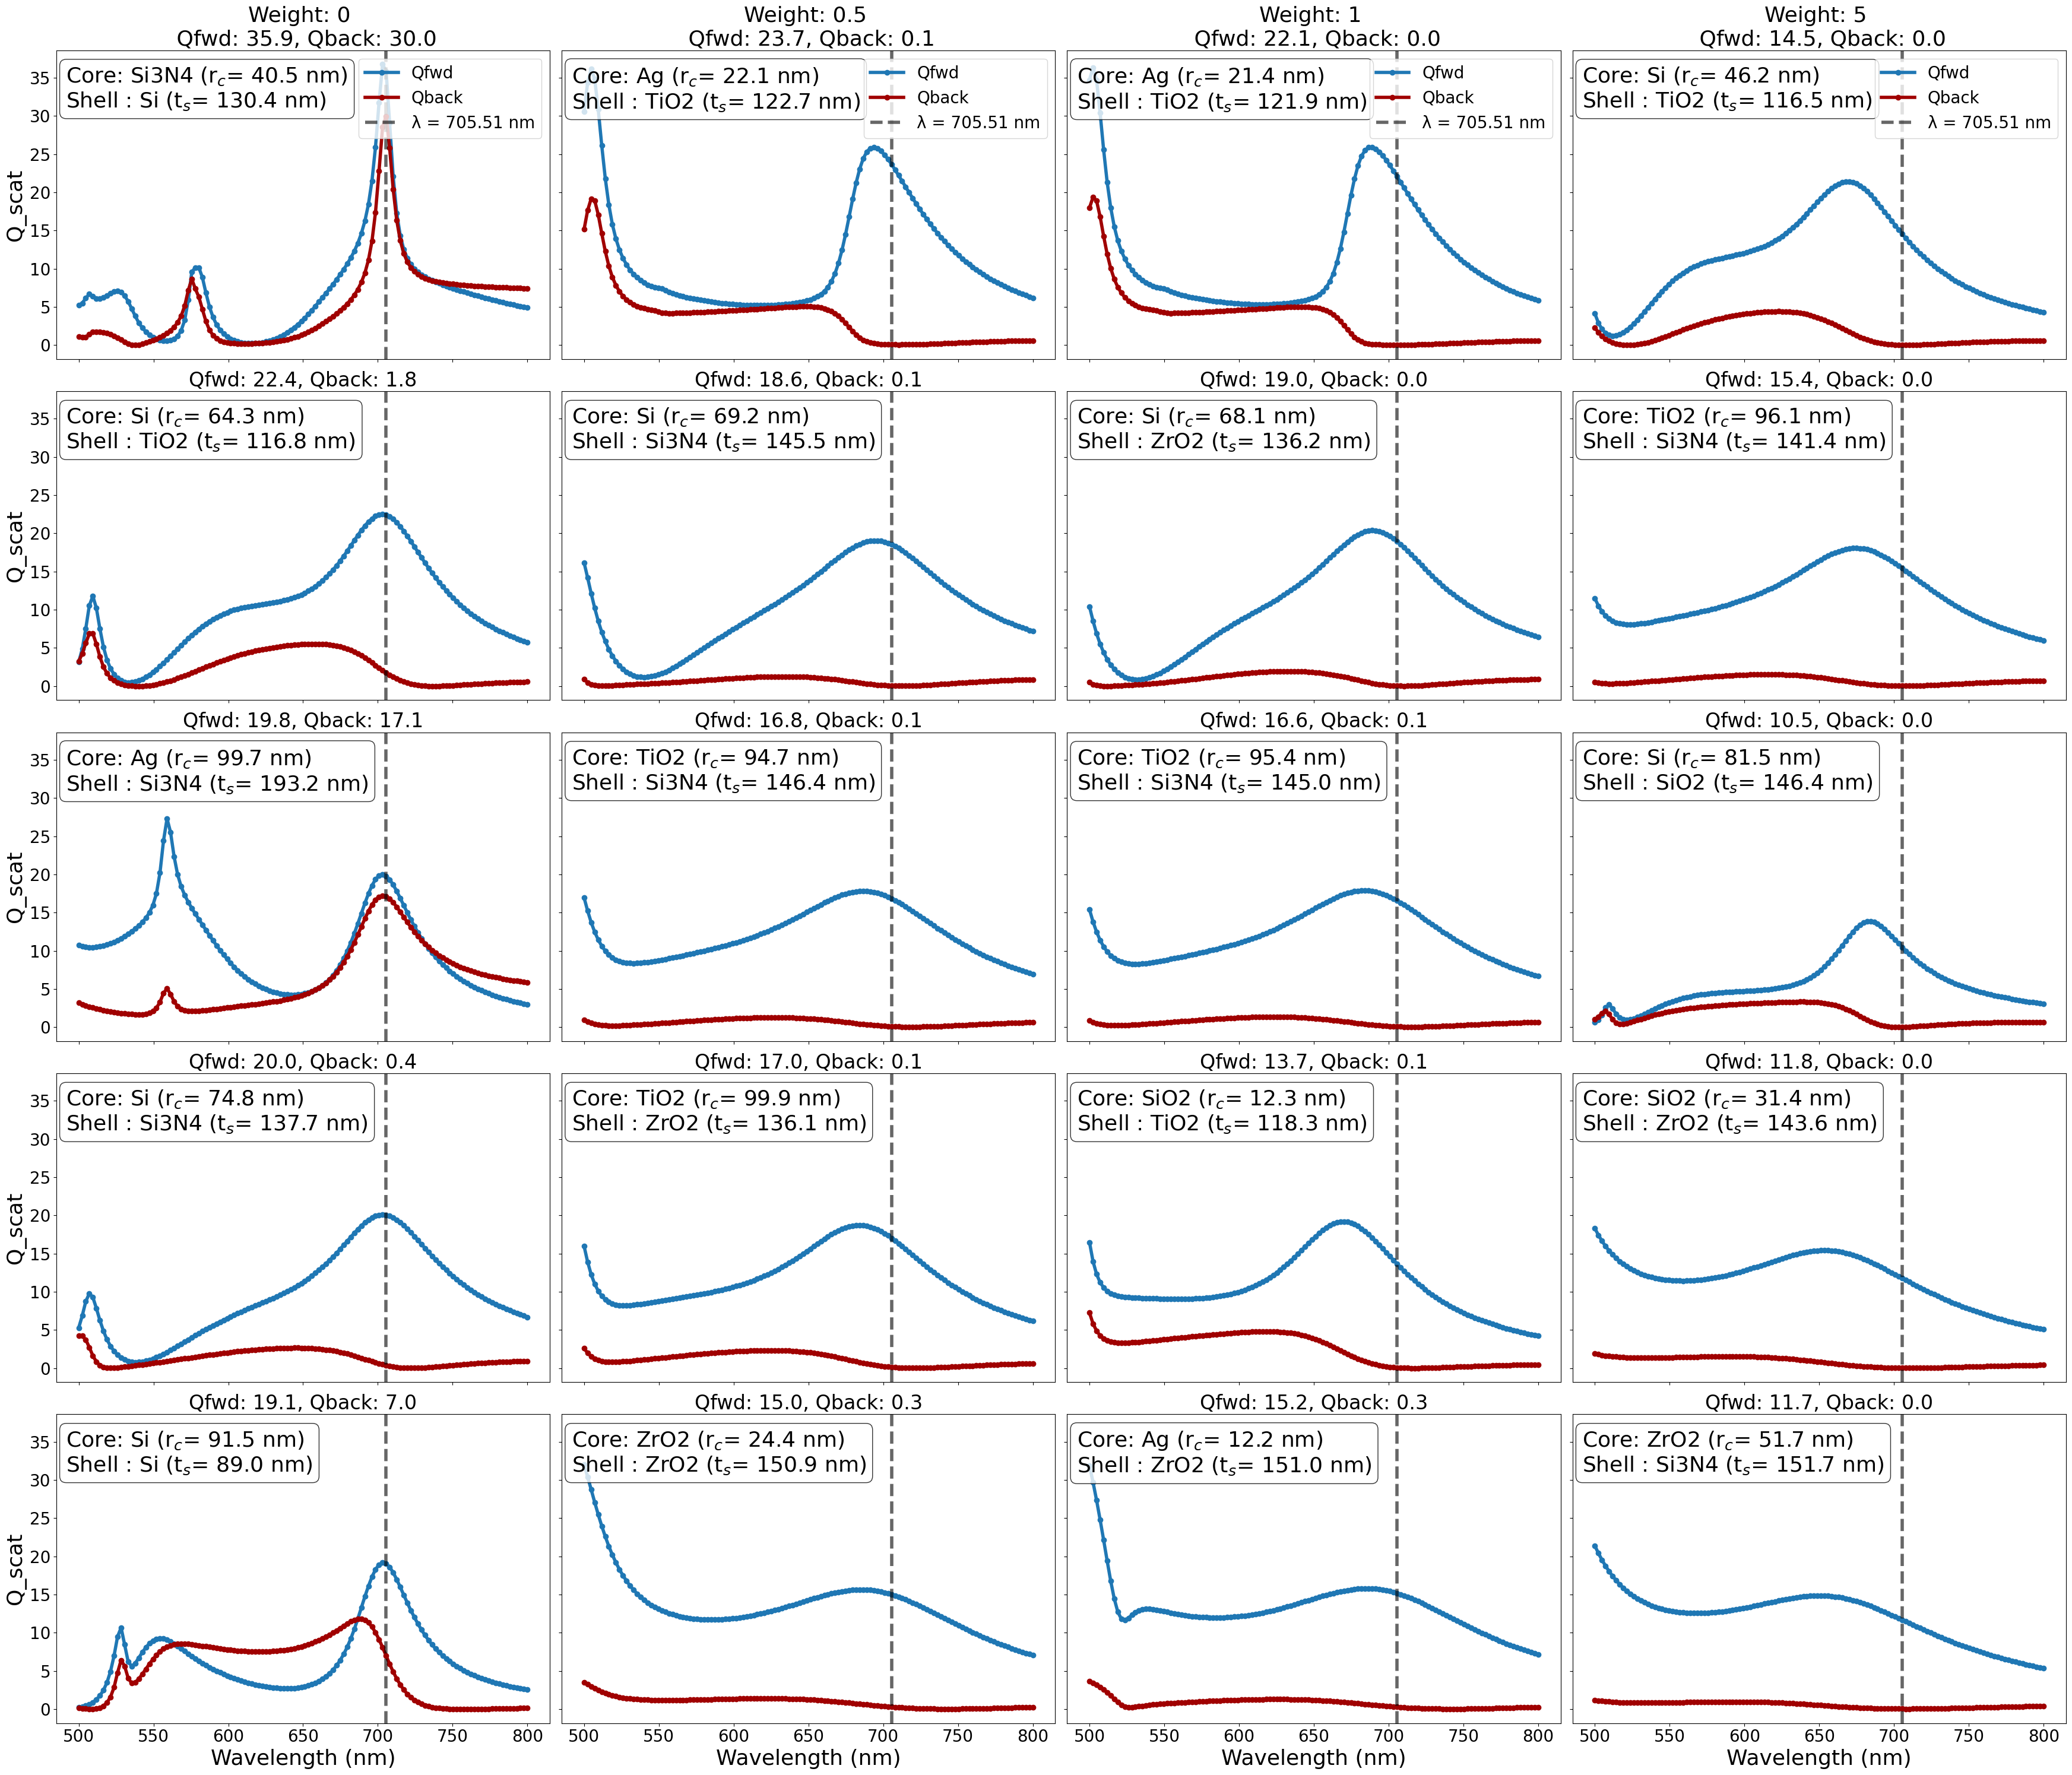

In [20]:
%run utils_plot.py
plot_best_geometries_by_weights(best_geometries_by_weight, wavelengths_original, wavelengths_new, weights=weight_series, target_lambda_index=target_lambda_index)

## Design Space

In [2]:
import pandas as pd

# File path for weight = 1
results_file = 'optimized_data/newData_122500/03_5000latent_droprow_geometries_weight_1.csv'

# Load the optimized geometries DataFrame
df_weight1 = pd.read_csv(results_file)
df_weight1.head

<bound method NDFrame.head of      mat_core mat_shell     r_core     r_shell  Total Loss  \
0          Au        Au   3.374450    9.929068   -0.000907   
1       Si3N4      ZrO2  99.992828  199.802689   -1.019740   
2        ZrO2        Si  16.713394   83.511513   -1.074640   
3          Si      SiO2  80.947556  172.269379   -1.379252   
4          Au        Au   1.294267   16.902552   -0.001011   
...       ...       ...        ...         ...         ...   
4420     TiO2      TiO2   1.000490    2.034951   -0.002948   
4421       Ag        Au  89.368797  193.437592   -1.270546   
4422     SiO2      TiO2   8.612384  117.790993   -1.451789   
4423       Ag      TiO2   1.464265    2.199048   -0.007130   
4424     TiO2      ZrO2  60.086510  147.048447   -1.488840   

                                               mie_Qfwd  \
0     [0.002951147206629888, 0.002779093477554295, 0...   
1     [6.514240793427257, 12.308953987188607, 26.757...   
2     [5.018798426566378, 4.572382904984019, 4.5

In [4]:
# Filter rows where r_core is greater than r_shell
rows_with_r_core_gt_r_shell = df_weight1[df_weight1['r_core'] > df_weight1['r_shell']]

# Print the number of such rows
print(f"Number of rows with r_core > r_shell: {len(rows_with_r_core_gt_r_shell)}")


Number of rows with r_core > r_shell: 0


In [5]:
df_weight1['t_shell'] = df_weight1['r_shell'] - df_weight1['r_core']
df_weight1.head()

,mat_core,mat_shell,r_core,r_shell,Total Loss,mie_Qfwd,mie_Qback,target_lambda,t_shell
0,Au,Au,3.374450,9.929068,-0.000907,"[0.002951147206629888, 0.002779093477554295, 0...","[0.002924546631979529, 0.002754991879571866, 0...",704.761905,6.554618
1,Si3N4,ZrO2,99.992828,199.802689,-1.019740,"[6.514240793427257, 12.308953987188607, 26.757...","[9.469348824869876, 12.60032868267615, 19.8570...",704.761905,99.809860
2,ZrO2,Si,16.713394,83.511513,-1.074640,"[5.018798426566378, 4.572382904984019, 4.53614...","[2.4809164825753856, 2.618965616769633, 2.5071...",704.761905,66.798119
3,Si,SiO2,80.947556,172.269379,-1.379252,"[13.367026838792574, 12.327667898809473, 11.31...","[0.1515886293843685, 0.06830714745406302, 0.01...",704.761905,91.321823
4,Au,Au,1.294267,16.902552,-0.001011,"[0.026015244797437952, 0.024469361839041658, 0...","[0.025351795329560778, 0.02386856669309116, 0....",704.761905,15.608285


Number of optimized results with Core Material 'Si': 686


/tmp/ipykernel_24973/3311881279.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Shell Material Numeric'] = filtered_df['mat_shell'].map(shell_material_mapping)


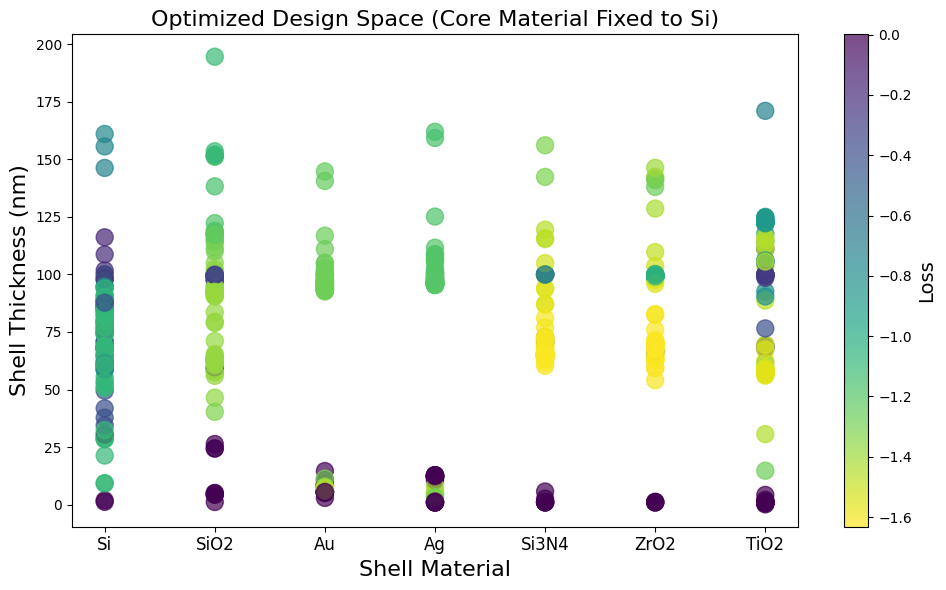

In [8]:
filtered_df = df_weight1[df_weight1['mat_core'] == 'Si']
print(f"Number of optimized results with Core Material 'Si': {len(filtered_df)}")

# Define the order of shell materials for consistent plotting
shell_material_order = ['Si', 'SiO2', 'Au', 'Ag', 'Si3N4', 'ZrO2', 'TiO2']
shell_material_mapping = {material: idx for idx, material in enumerate(shell_material_order)}

# Map shell materials to numerical values for plotting
filtered_df['Shell Material Numeric'] = filtered_df['mat_shell'].map(shell_material_mapping)

# Extract values for plotting
shell_material_numeric = filtered_df['Shell Material Numeric']
shell_thickness = filtered_df['t_shell']
total_loss = filtered_df['Total Loss']

# Create the scatter plot with colorbar for total loss values
plt.figure(figsize=(10, 6))
# scatter = plt.scatter(shell_material_numeric, shell_thickness, c=total_loss, cmap='viridis_r', alpha=0.7, marker='o', rasterized=True)
scatter = plt.scatter(shell_material_numeric, shell_thickness, c=total_loss, cmap='viridis_r', alpha=0.7, marker='o', s=150, rasterized=True)

# Add colorbar for total loss values
cbar = plt.colorbar(scatter)
cbar.set_label('Loss', fontsize=14)

# Customize the plot
plt.xticks(ticks=np.arange(len(shell_material_order)), labels=shell_material_order, fontsize=12)
plt.xlabel('Shell Material', fontsize=16)
plt.ylabel('Shell Thickness (nm)', fontsize=16)
plt.title('Optimized Design Space (Core Material Fixed to Si)', fontsize=16)
plt.tight_layout()

# Show the plot
plt.savefig('save_figures/new_plot/design_space_tShell_weight1_5000space.svg', bbox_inches='tight', dpi=300)
plt.show()


In [9]:
filtered_df

,mat_core,mat_shell,r_core,r_shell,Total Loss,mie_Qfwd,mie_Qback,target_lambda,t_shell,Shell Material Numeric
3,Si,SiO2,80.947556,172.269379,-1.379252,"[13.367026838792574, 12.327667898809473, 11.31...","[0.1515886293843685, 0.06830714745406302, 0.01...",704.761905,91.321823,1
8,Si,Si3N4,71.685188,138.770691,-1.623002,"[20.820324757777843, 19.245919041426784, 16.02...","[0.03433899591061971, 0.09307295143148538, 0.2...",704.761905,67.085503,4
9,Si,Si,5.317989,82.919464,-1.060383,"[4.57916066375265, 4.9227346682615485, 5.05665...","[1.7917478180073352, 2.3915856579654737, 2.486...",704.761905,77.601475,0
13,Si,Si,4.548092,165.516861,-0.767503,"[12.094055106932213, 12.15273379177453, 11.022...","[0.8024588295274452, 0.47438504041146146, 0.19...",704.761905,160.968769,0
18,Si,Au,95.677956,102.754539,-1.444705,"[5.405357305972339, 4.716346633206971, 5.35865...","[0.10553709383309841, 0.0002963608403040221, 0...",704.761905,7.076584,2
...,...,...,...,...,...,...,...,...,...,...
4385,Si,Si3N4,41.975368,198.024033,-1.314482,"[21.548086015064573, 21.856665754788605, 23.82...","[5.913526835577178, 4.192786382413488, 3.99881...",704.761905,156.048664,4
4386,Si,Ag,89.921028,196.288025,-1.197315,"[43.5086046529799, 37.93949129758491, 34.71911...","[5.719720641856001, 4.287672831408872, 2.97687...",704.761905,106.366997,3
4407,Si,TiO2,48.503479,170.669312,-0.882786,"[9.198420406452826, 17.155860240768146, 13.204...","[1.3747318447768389, 5.115988828451598, 5.0120...",704.761905,122.165833,6
4409,Si,TiO2,57.366360,114.723572,-1.555875,"[11.257998293177469, 15.136522528308035, 9.874...","[0.12297642675338581, 0.016657213895621917, 0....",704.761905,57.357212,6
